### Notebook 1: Gaussian Process for Surrogate Modeling

In this notebook, we will walk through the process of building a surrogate model with *Gaussian Process* (GP). We will use **GPflow** library to streamline the model training/inference process.

> GPflow depends on both TensorFlow and TensorFlow Probability, which require very specific versions to be compatible. For example:
>
> **`!pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0`**
>
> For more details, please refer to the [official documents](https://gpflow.github.io/GPflow/2.9.1/installation.html).

### 0. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc

import gpflow
import tensorflow as tf

### 1. Problem Setup

In this notebook, we aim to build a GP-based surrogate model to approximate the following analytical function:

\begin{equation}
y = (6x-2)^2sin(12x-4), x \in [0,1]
\end{equation}

In [2]:
# Define 1D function
def func(X):
    """Reference function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

#### 1.1 Generate train/test dataset

We use Latin Hypercube sampling method to create random samples for training.

In [3]:
# Training data
X_train = np.array([0.0, 0.15, 0.3, 0.4, 0.54, 0.7, 0.8, 1]).reshape(-1,1)
# X_train = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]).reshape(-1,1)
y_train = func(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = func(X_test)

#### 1.2 Visualization

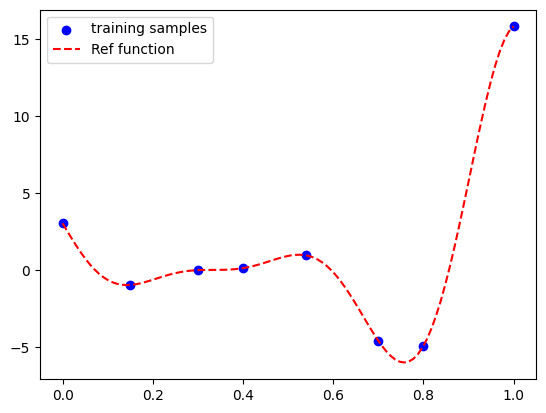

In [4]:
fig, ax = plt.subplots()
ax.scatter(X_train.flatten(), y_train, c='b', label='training samples')
ax.plot(X_test.flatten(), y_test, '--r', label='Ref function')
ax.legend();

### 2. Surrogate Modeling

#### 2.1 Configuring GP model

To develop a GP-based surrogate model, we use the well-established library *GPflow*. This library allows an easy configuraion of the Gaussian Process model and provides different means for training the model. 

To begin with, let's create a wrapper function to initiate a GP model. In GPflow, configuring a GP model requires several key ingredients:
- tuple of training data
- kernel function
- mean function

For both kernel and mean functions, GPflow offers many built-in options that cover many of the use cases. In our current implementation, we will use the most popular `gpflow.kernels.SquaredExponential` for the kernel (also known as Gaussian kernel or RBF kernel), and `gpflow.functions.Polynomial(0)` for the mean function, which stands for a 0-th order polynomial, i.e., a constant value. Later during training, GPflow will optimize the unknown constant mean function, as well as the variance and length scale parameters.

As a good practice, we also provide an initial guess for the kernel variance and length scale parameters, respectively. For the variance, we simply use the variance of the training data as the initial guess. For the length scale, we adopt a multi-start strategy, which we will explain in the next section.

In [5]:
def config_GP(lengthscale, X_train, y_train):
    
    # Set up the kernel
    kernel = gpflow.kernels.SquaredExponential(variance=np.var(y_train), lengthscales=lengthscale)

    # Set up the model
    model = gpflow.models.GPR(
        (X_train, y_train.reshape(-1, 1)),
        kernel=kernel,
        mean_function=gpflow.functions.Polynomial(0)
    )

    return model

#### 2.2 Multi-start optimization strategy

By default, GPflow adopts the *maximum likelihood estimation* (MLE) approach to learn the GP model parameters. Essentially, this means that the GP model parameters are optimized such that the likelihood of observing the data is maximized. Under the hood, GPflow uses the `L-BFGS` algorithm from `scipy` as the main optimizer. 

Since `L-BFGS` algorithm is only a local optimization algorithm, it is usually a good practice to employ a **multi-start** strategy, where we run the same optimization routine multiple times, each with a different set of initial values for the GP model parameters. This would give us a higher chance to reach the global optimal.

In our current implementation, we apply the multi-start strategy on the length scale parameter, one of the most important parameters that determines the performance of the GP. More specifically, we use Latin Hypercube sampling approach to randomly generate initial guesses for the length scale value and we perform optimization starting from those individual random guesses. 

As a rule of thumb, we can sample in the range of $[0.01, 100]$, which covers most of the realistic use cases and delivers empirically good results.

In [6]:
# We sample in the log-space
n_restarts = 5
lb, ub = -2, 2
lhd = qmc.LatinHypercube(d=X_train.shape[1], seed=42).random(n_restarts)
length_scales = (ub-lb)*lhd + lb
length_scales = 10**length_scales

#### 2.3 Training GP model

In [7]:
# Configure the GP training procedure
models = []
log_likelihoods = []

with tf.device("CPU:0"):

    for i, length_scale in enumerate(length_scales):
        print(f"Performing {i+1}-th optimization:")

        # Init model
        model = config_GP(length_scale, X_train, y_train)

        # Training
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

        # Record keeping
        models.append(model)
        log_likelihoods.append(model.log_marginal_likelihood().numpy())
        print(f"Log likelihood: {log_likelihoods[-1]}")

# Select the model with the highest log-marginal likelihood
best_model_index = np.argmax(log_likelihoods)
best_model = models[best_model_index]

print(f"Best model log-marginal likelihood: {log_likelihoods[best_model_index]}")

Performing 1-th optimization:
Log likelihood: -25.799839758012475
Performing 2-th optimization:
Log likelihood: -25.799839758391684
Performing 3-th optimization:
Log likelihood: -24.35704833993556
Performing 4-th optimization:
Log likelihood: -24.357048300246383
Performing 5-th optimization:
Log likelihood: -25.79983981613308
Best model log-marginal likelihood: -24.357048300246383


#### 2.4 Performance assessment

First, we can display the summary of the trained GP model.

In [8]:
gpflow.utilities.print_summary(best_model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value       │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.mean_function.w     │ Parameter │ Identity         │         │ True        │ (1, 1)  │ float64 │ [[4.35343]] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 65.39011    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.162]     │
├─────────────────────────┼───────────┼──────────────────┼──────

Next, we assess the accuracy of the trained GP model. 

In [9]:
# GP model predicting
f_mean, f_var = best_model.predict_f(X_test, full_cov=False)
f_mean = f_mean.numpy().flatten()
f_var = f_var.numpy().flatten()

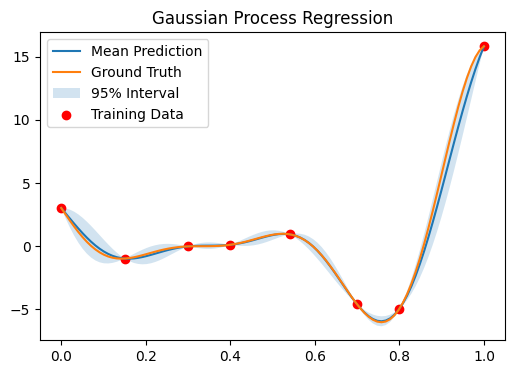

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(X_test.flatten(), f_mean, label='Mean Prediction')
plt.plot(X_test.flatten(), y_test.flatten(), label='Ground Truth')
plt.fill_between(X_test.flatten(), f_mean-2*np.sqrt(f_var), f_mean+2*np.sqrt(f_var), 
                 alpha=0.2, label='95% Interval')
plt.scatter(X_train.flatten(), y_train.flatten(), c='r', label='Training Data')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

### 3. GP class

Now, we can wrap the developed GP training/inference pipeline as a class.

In [ ]:
import numpy as np
from scipy.stats import qmc

import gpflow
import tensorflow as tf

class GPflowWrapper:
    """
    Wrapper class for GPflow.
    """

    def __init__(self, kernel="squared_exponential", mean_func="const", n_restarts=5):
        """
        Initialize the GPflowWrapper class.

        Args:
        - kernel (str): The kernel function to use. Default is "squared_exponential".
        - mean_func (str): The mean function to use. Default is "const".
        - n_restarts (int): The number of random restarts for hyperparameter optimization. Default is 5.
        """
        self.kernel = kernel
        self.mean_func = mean_func
        self.n_restarts = n_restarts
        self.GP = None


    def fit(self, X_train, y_train, verbose=True):
        """
        Fit the GP model.

        Args:
        - X_train (np.ndarray): The training input data.
        - y_train (np.ndarray): The training output data.
        - verbose (bool): Whether to print out the optimization process. Default is True.
        """
        self.dim = X_train.shape[1]
        
        models = []
        log_likelihoods = []

        # Generate initial guesses for length scale
        self._init_kernel_params(y_train)
        kernel_list = self._build_kernels()

        with tf.device("CPU:0"):

            for i, kernel in enumerate(kernel_list):
                if verbose:
                    print(f"Performing {i+1}-th optimization:")

                # Set up the model
                model = gpflow.models.GPR(
                    (X_train, y_train.reshape(-1, 1)),
                    kernel=kernel,
                    mean_function=self._build_mean_function()
                )

                # Training
                opt = gpflow.optimizers.Scipy()
                opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

                # Record keeping
                models.append(model)
                log_likelihoods.append(model.log_marginal_likelihood().numpy())
                if verbose:
                    print(f"Log likelihood: {log_likelihoods[-1]}")

        # Select the best model
        best_model_index = np.argmax(log_likelihoods)
        self.GP = models[best_model_index]
        if verbose:
            print(f"Best model log-marginal likelihood: {log_likelihoods[best_model_index]}")



    def _init_kernel_params(self, y):
        """
        Initialize the kernel parameters.

        Args:
        - y (np.ndarray): The training output data.
        """

        if self.kernel == "squared_exponential":
            # Default range
            lb, ub = -2, 2

            # Latin Hypercube sampling (in log space)
            lhd = qmc.LatinHypercube(d=self.dim, seed=42).random(self.n_restarts)
            lhd = (ub-lb)*lhd + lb

            # Convert back to the original scale
            self.length_scales = 10**lhd

            # Init process variance
            self.variances = np.var(y)*np.ones(self.n_restarts)
        
        else:
            raise KeyError(f"{self.kernel} kernel not supported yet!")
        


    def _build_kernels(self):
        """
        Build a list of kernels. Each kernel has a different initial hyperparameters. 
        """
        kernel_list = []

        if self.kernel == "squared_exponential":
            for i in range(self.n_restarts):
                kernel_list.append(gpflow.kernels.SquaredExponential(
                    variance=self.variances[i], 
                    lengthscales=self.length_scales[i]))
            
        else:
            raise KeyError(f"{self.kernel} kernel not supported yet!")
        
        return kernel_list
        


    def _build_mean_function(self):
        """
        Build the mean function.
        """
        if self.mean_func == "const":
            return gpflow.functions.Polynomial(0)
        else:
            raise KeyError(f"{self.mean_func} mean function not supported yet!")



    def predict(self, X_test, full_cov=False):
        """
        Predict the mean and variance of the test data.

        Args:
        - X_test (np.ndarray): The test input data.
        - full_cov (bool): Whether to return the full covariance matrix. Default is False.

        Returns:
        - f_mean (np.ndarray): The mean of the predicted output.
        - f_var (np.ndarray): The variance of the predicted output.
        """

        f_mean, f_var = self.GP.predict_f(X_test, full_cov=full_cov)
        f_mean = f_mean.numpy().flatten()
        f_var = f_var.numpy().flatten()

        return f_mean, f_var